<a href="https://colab.research.google.com/github/bochendong/car-racing-revistied/blob/main/car-racing-dann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# run this block for colab enviorment settings


'''%%capture
!pip install swig
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] pyglet
!pip install wandb
# !pip install gym==0.21.0
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq
!pip install gym[box2d]
!pip install box2d-kengz'''

'%%capture\n!pip install swig\n!sudo apt update && sudo apt install python-opengl\n!sudo apt update && sudo apt install xvfb\n!pip install gym-notebook-wrapper stable-baselines[mpi] pyglet\n!pip install wandb\n# !pip install gym==0.21.0\n!pip install pyvirtualdisplay -qq\n!pip install folium==0.2.1\n!apt-get install -y xvfb python-opengl ffmpeg -qq\n!pip install gym[box2d]\n!pip install box2d-kengz'

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import random
import os
import glob
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from torch.autograd import Function

In [16]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
env = gym.make('CarRacing-v2')
init_state = env.reset()

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if (os.path.exists("./output_r")) == False:
    os.mkdir("output_r")
    
for epoch in range (3000):
    files = glob.glob("./output_r/*.png")
    
    for f in files:
        os.remove(f)

# Environment Car-racing

In [19]:
ORG_B0 = np.array([100, 202, 100])
ORG_B1 = np.array([100, 228, 100])

Unseen_1_B0 = np.array([139, 177, 155])
Unseen_1_B1 = np.array([145, 202, 156])

Unseen_2_B0 = np.array([99, 160, 177])
Unseen_2_B1 = np.array([115, 159, 174])

def change_background_color(img_rgb, new_background_color, original_background_color,  similarity_threshold=25):
    # Calculate the absolute difference between the image and the original background color
    color_difference = np.abs(img_rgb - original_background_color)

    # Create a boolean mask to identify the background pixels
    background_mask = np.all(color_difference <= similarity_threshold, axis=-1)

    # Replace the original background color with the new background color
    img_rgb[background_mask] = new_background_color

    return img_rgb


class Env():
    def __init__(self, color, seed=0):
        """
        Initialize the environment with the given color and seed.
        
        :param color: str, color for the environment, 'g' for green
        :param seed: int, seed for the environment
        """

        self.env = gym.make('CarRacing-v2')
        self.env.reset(seed=seed)
        
        self.color = color
        self.reward_threshold = 1000
        self.reset()

    def reset(self):
        """
        Reset the environment and return the initial state.
        
        :return: np.array, initial state
        """
        self.counter = 0
        self.die = False
        self.av_r = self.reward_memory()

        img_rgb = self.env.reset()
        if (self.color == 'c1'):
            img_rgb = change_background_color(img_rgb, Unseen_1_B0, ORG_B0)
            img_rgb = change_background_color(img_rgb, Unseen_1_B1, ORG_B1)
        elif (self.color == 'c2'):
            img_rgb = change_background_color(img_rgb, Unseen_2_B0, ORG_B0)
            img_rgb = change_background_color(img_rgb, Unseen_2_B1, ORG_B1)

        img_rgb = img_rgb / 128. - 1

        self.stack = [img_rgb] * 4
        return np.array(self.stack)


    def step(self, action):
        """
        Take a step in the environment using the given action, reconstrcut the 
        reward fucntion.
        
        :param action: np.array, action to take in the environment
        :return: tuple, (state, total_reward, done, die)
        """
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)

            if (self.color == 'c1'):
                img_rgb = change_background_color(img_rgb, Unseen_1_B0, ORG_B0)
                img_rgb = change_background_color(img_rgb, Unseen_1_B1, ORG_B1)
            elif (self.color == 'c2'):
                img_rgb = change_background_color(img_rgb, Unseen_2_B0, ORG_B0)
                img_rgb = change_background_color(img_rgb, Unseen_2_B1, ORG_B1)

            if die: reward += 100

            if self.color == 'g' and np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05

            total_reward += reward

            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break

        img_rgb = img_rgb / 128. - 1


        self.stack.pop(0)
        self.stack.append(img_rgb)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def step_eval(self, action):
        """
        Take a step in the environment using the given action (for evaluation).
        
        :param action: np.array, action to take in the environment
        :return: tuple, (state, reward, done, _)
        """
        img_rgb, reward, done, _ = self.env.step(action)

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        return np.array(self.stack), reward, done, _

    def render(self, *arg):
        """
        Render the environment.
        
        :param arg: tuple, arguments for the rendering function
        """
        self.env.render(*arg)

    @staticmethod
    def reward_memory():
        """
        Create a reward memory function to store the last `length` rewards.
        
        :return: function, reward memory function
        """
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

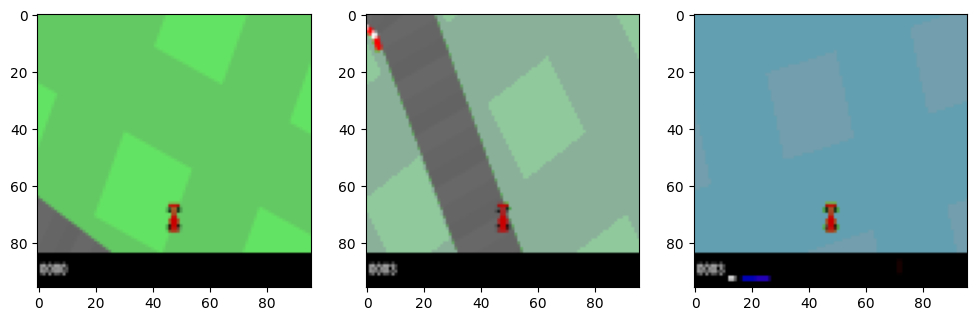

In [20]:
source_env = Env(color = 'g', seed = 0)
unseen_1_env = Env(color = 'c1', seed = 0)
unseen_2_env = Env(color = 'c2', seed = 0)

discrete_actions = {0 : np.array([0,0,0]),       # do nothing
                                 1 : np.array([-1,0,0]),      # steer sharp left
                                 2 : np.array([1,0,0]),       # steer sharp right
                                 3 : np.array([-0.5,0,0]),    # steer left
                                 4 : np.array([0.5,0,0]),     # steer right
                                 5 : np.array([0,1,0]),       # accelerate 100%
                                 6 : np.array([0,0.5,0]),     # accelerate 50%
                                 7 : np.array([0,0.25,0]),    # accelerate 25%
                                 8 : np.array([0,0,1]),       # brake 100%
                                 9 : np.array([0,0,0.5]),     # brake 50%
                                 10 : np.array([0,0,0.25])}   # brake 25%

def get_obs(env):
    n_actions = len(discrete_actions)
    for i in range (0, 30):
        action = torch.randint(low=0, high=11, size=(1,))
        action_transfered = discrete_actions.get(int(action[0]))

        obs, reward, done, _ = env.step([action_transfered[0], action_transfered[1], action_transfered[2]])

    return (obs[0] + 1) / 2.0

env_preview = []

env_preview.append(get_obs(source_env))
env_preview.append(get_obs(unseen_1_env))
env_preview.append(get_obs(unseen_2_env))


f, axs = plt.subplots(1, 3, figsize = (12, 4))
axs = axs.flatten()

for img, ax in zip(env_preview, axs):
    ax.imshow(img)

plt.show()

# DANN

In [21]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None  

class DANN(nn.Module):
    def __init__(self, num_out=2):
        """
        Initialize the DANN module.
        
        :param num_out: int, number of output units
        """
        super(DANN, self).__init__()

        self.sketch = nn.Sequential(
            nn.Conv3d(4, 4, kernel_size=(1, 1, 3), stride=1),
            nn.ReLU(),
        )

        self.feature = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
        )

        self.cnn_base = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 2),
        )

        self.value_head = nn.Sequential(
            nn.Linear(256, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 100),
            nn.ReLU()
        )

        self.alpha_head = nn.Sequential(
            nn.Linear(100, 3),
            nn.Softplus()
        )

        self.beta_head = nn.Sequential(
            nn.Linear(100, 3),
            nn.Softplus()
        )

        self.apply(self._weights_init)

    def forward(self, input, a=0.1):
        """
        Forward pass through the DANN module.
        
        :param input: torch.Tensor, input tensor
        :param alpha: float, alpha parameter for the ReverseLayerF
        :return: tuple, (alpha, beta), value, domain_output, sketch
        """
        sketch = self.sketch(input)
        sketch = torch.squeeze(sketch)

        feature = self.feature(sketch)

        out = self.cnn_base(feature)
        out = out.view(-1, 256)
        v = self.value_head(out)
        out = self.fc(out)

        alpha = self.alpha_head(out) + 1
        beta = self.beta_head(out) + 1

        feature = feature.view(-1, 64 * 5 * 5)
        reverse_feature = ReverseLayerF.apply(feature, a)
        domain_output = self.domain_classifier(reverse_feature)

        return (alpha, beta), v, domain_output, sketch

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)


In [22]:
def get_random(state):
    red_scale, green_scale, blue_scale = 1., 1., 1.
    base_scale = 0.5
    while (red_scale == green_scale == blue_scale):
        add_green = random.randint(0, 1)
        add_red = random.randint(0, 1)
        add_blue = random.randint(0, 1)
        if (add_red): 
            red_scale = random.uniform(0.5, 1.1)
        if (add_green): 
            green_scale = random.uniform(0.5, 1.1)
        if (add_blue): 
            blue_scale = random.uniform(0.5, 1.1)
            
    for i in range (0, 4):
        s = torch.transpose(state[i], 0, 2)
        road = s [1] - s [0] * 0.6 - s[2] * 0.4
        road = torch.stack((road, road, road), 0)
        ones = torch.ones(3, 96, 96).to(device)

        road_mask = torch.logical_xor(road, ones)
        road_layer = s * road_mask

        light_green = 202 / 128. - 1
        light_green_mask = torch.logical_xor(s - light_green , ones)
        light_green_layer = s * light_green_mask

        dark_green = 228 / 128. - 1
        dark_green_mask = torch.logical_xor(s - dark_green , ones)
        dark_green_layer = s * dark_green_mask

        bg_layer = light_green_layer + dark_green_layer

        ones = torch.ones(96, 96).to(device)
        back_ground_mask = torch.logical_xor(bg_layer[1], ones)

        red_channel = (back_ground_mask * 128) /128. - 1
        green_channel = (back_ground_mask * 128) /128. - 1
        blue_channel = (back_ground_mask * 128) /128. - 1

        if (add_red): red_channel = bg_layer[1] * red_scale
        if (add_green): green_channel = bg_layer[1] * green_scale
        if (add_blue): blue_channel = bg_layer[1] * blue_scale

        new_bg_layer = torch.stack((red_channel, green_channel, blue_channel), 0)

        new_state = new_bg_layer + road_layer

        state[i] = torch.transpose(new_state, 0, 2)
        
    return state  

def get_random_buffer(buffer, batch_size):
    target_buffer = buffer.clone()
    for i in range (batch_size):
        target_buffer[i] = get_random(target_buffer[i])
    return target_buffer 

# Agent

In [23]:
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler, BatchSampler
import matplotlib.pyplot as plt

class Agent:
    max_grad_norm = 0.5
    clip_param = 0.1
    ppo_epoch = 10

    transition = np.dtype([
        ('s', np.float64, (4, 96, 96, 3)),
        ('a', np.float64, (3,)),
        ('a_logp', np.float64),
        ('r', np.float64),
        ('s_', np.float64, (4, 96, 96, 3))
    ])

    def __init__(self, net, criterion, optimizer, buffer_capacity=2000, batch_size=128):
        """
        Initialize the Agent.
        
        :param net: neural network for the agent
        :param criterion: loss function
        :param optimizer: optimizer for the network
        :param buffer_capacity: int, capacity of the buffer
        :param batch_size: int, batch size for training
        """
        self.net = net
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.criterion = criterion
        self.optimizer = optimizer

        self.source_buffer = np.empty(self.buffer_capacity, dtype=self.transition)
        self.counter = 0

    def select_action(self, state):
        """
        Select action based on the given state.
        
        :param state: numpy array, state representation
        :return: tuple, (action, action_log_probability)
        """
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            out = self.net.sketch(state)
            out = torch.squeeze(out)
            out = self.net.feature(out)

            out = self.net.cnn_base(out)
            out = out.view(-1, 256)
            out = self.net.fc(out)
            alpha = self.net.alpha_head(out) + 1
            beta = self.net.beta_head(out) + 1

        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def store(self, transition):
        """
        Store the transition in the buffer.
        
        :param transition: tuple, (state, action, action_log_probability, reward, next_state)
        :return: bool, True if the buffer is full, False otherwise
        """
        
        self.source_buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True

        return False

    def _prepare_tensors(self):
        s = torch.tensor(self.source_buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.source_buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.source_buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.source_buffer['s_'], dtype=torch.double).to(device)
        old_a_logp = torch.tensor(self.source_buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        return s, a, r, s_, old_a_logp
    
    def _prepare_domain_labels(self):
        source_domain_label = torch.zeros(self.batch_size).long().to(device)
        target_domain_label = torch.ones(self.batch_size).long().to(device)
        return source_domain_label, target_domain_label

    def _compute_advantage(self, s, r, s_):
        with torch.no_grad():
            target_v = r + 0.99 * self.net(s_)[1]
            adv = target_v - self.net(s)[1]
        return target_v, adv

    def _calculate_losses(self, s, a, old_a_logp, adv, index, eta):
        (alpha, beta), v, domain_out, s_sketch = self.net(s[index], eta)

        source_domain_loss = self.criterion(domain_out, self.source_domain_label)
        source_domain_correct = (torch.argmax(domain_out, dim=1) == self.source_domain_label).sum().item()

        _, _, domain_out, t_sketch = self.net(self.target_batch, eta)
        target_domain_loss = self.criterion(domain_out, self.target_domain_label)
        target_domain_correct = (torch.argmax(domain_out, dim=1) == self.target_domain_label).sum().item()

        dist = Beta(alpha, beta)
        a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
        ratio = torch.exp(a_logp - old_a_logp[index])
        surr1 = ratio * adv[index]
        surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
        action_loss = -torch.min(surr1, surr2).mean()
        value_loss = F.smooth_l1_loss(self.net(s[index])[1], self.target_v[index])

        loss = action_loss + 2. * value_loss + source_domain_loss + target_domain_loss

        return loss, source_domain_correct, target_domain_correct, s_sketch, t_sketch

    def _save_images(self, epoch, image_array):
        f, axs = plt.subplots(2, 10, figsize = (16, 4))
        axs = axs.flatten()
        for img, ax in zip(image_array, axs):
            ax.imshow(img)
        f.savefig('./output_r/%04d.png' % epoch)
        plt.close(f)

    def _get_sample_random_result(self, index):
        s = torch.tensor(self.source_buffer['s'], dtype=torch.double).to(device)
        # return change_background_color(s[index], (100/128. - 1, 202/128. - 1, 100/128. - 1))
        return get_random_buffer(s[index], self.batch_size)

    def update(self, epoch, eta=0.1):
        # Prepare tensors from the source_buffer
        s, a, r, s_, old_a_logp = self._prepare_tensors()
        self.target_v, adv = self._compute_advantage(s, r, s_)
        self.source_domain_label, self.target_domain_label = self._prepare_domain_labels()

        image_array, source_acc_array, target_acc_array = [], [], []

        for _ in range(self.ppo_epoch):
            total = 0
            source_domain_correct, target_domain_correct = 0, 0
            add_image = True

            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, True):
                total += self.batch_size
                self.target_batch = get_random_buffer(s[index], self.batch_size)

                loss, src_correct, tgt_correct, s_sketch, t_sketch = self._calculate_losses(s, a, old_a_logp, adv, index, eta)
                source_domain_correct += src_correct
                target_domain_correct += tgt_correct

                if add_image:
                    image_array.extend([s_sketch[0][0].reshape(96, 96).cpu().detach().numpy(),
                                        t_sketch[0][0].reshape(96, 96).cpu().detach().numpy()])
                    add_image = False

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            source_acc_array.append(source_domain_correct / total)
            target_acc_array.append(target_domain_correct / total)

        mean_source_acc = np.mean(source_acc_array)
        mean_target_acc = np.mean(target_acc_array)

        self._save_images(epoch, image_array)

        return mean_source_acc, mean_target_acc

In [24]:
def get_sample_buffer(source_env, agent):
    state = source_env.reset()
    sample = []
    index = [99, 65, 53, 121, 29, 67, 38, 88, 56, 21]
    for i in range(100):
        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = source_env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            should_update = agent.store((state, action, a_logp, reward, state_))
            if should_update:
                buffer = agent._get_sample_random_result(index)
                return buffer
            state = state_
            if done or die:
                break

    return sample
    
green_env = Env(color = 'g', seed = 0)
criterion = nn.CrossEntropyLoss().cuda()
net = DANN(num_out = 2).double().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
agent = Agent(net = net,  criterion = criterion,  optimizer = optimizer, buffer_capacity = 128, batch_size = 10)
sample_random_buffer = get_sample_buffer(green_env, agent)

In [28]:
sample_random_buffer.size()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([10, 4, 96, 96, 3])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


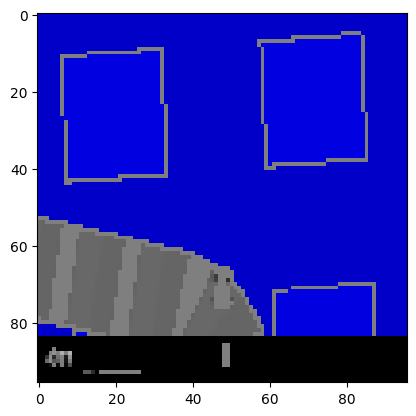

In [35]:
sample = (sample_random_buffer + 1)/2 
plt.imshow(sample[0][0].cpu())

# Testing

In [25]:
'''sample_buffer = sample_random_buffer.clone()
sample_buffer = (sample_buffer + 1) / 2.0

random_bg_images = []
for i in range (10):
    random_bg_images.append(sample_buffer[i][0].cpu().numpy())

f, axs = plt.subplots(2, 5, figsize = (12, 4))
axs = axs.flatten()

for img, ax in zip(random_bg_images, axs):
    ax.imshow(img)

plt.show()'''

'sample_buffer = sample_random_buffer.clone()\nsample_buffer = (sample_buffer + 1) / 2.0\n\nrandom_bg_images = []\nfor i in range (10):\n    random_bg_images.append(sample_buffer[i][0].cpu().numpy())\n\nf, axs = plt.subplots(2, 5, figsize = (12, 4))\naxs = axs.flatten()\n\nfor img, ax in zip(random_bg_images, axs):\n    ax.imshow(img)\n\nplt.show()'

In [26]:
def eval(agent, env):
    """
    Evaluate the agent on the given environment.

    :param agent: Agent, trained agent to be evaluated
    :param env: Environment, environment to evaluate the agent on
    :return: float, total reward received by the agent
    """
    score = 0
    state = env.reset()

    for t in range(1000):
        action, a_logp = agent.select_action(state)
        state_, reward, done, _ = env.step_eval(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
        score += reward
        state = state_

        if done:
            break

    return score


In [27]:
green_env = Env(color = 'g', seed = 0)
env_c1 = Env(color = 'c1', seed = 0)
env_c2 = Env(color = 'c2', seed = 0)

criterion = nn.CrossEntropyLoss().cuda()
net = DANN(num_out = 2).double().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
agent = Agent(net = net,  criterion = criterion,  optimizer = optimizer, buffer_capacity = 2048, batch_size = 128)

source_env = green_env
target_env = [env_c1, env_c2]

training_records = []
running_score_records = []
running_score = 0

c1_running_score = 0
c1_training_records = []
c1_running_score_records = []

c2_running_score = 0
c2_training_records = []
c2_running_score_records = []

eta = 0.2

for i_ep in range(3000):
    score = 0
    state = source_env.reset()

    for t in range(1000):
        action, a_logp = agent.select_action(state)
        state_, reward, done, die = source_env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
        score += reward

        should_update = agent.store((state, action, a_logp, reward, state_))

        if should_update:
            eta_max = 0.5 if i_ep < 500 else (0.45 if i_ep < 1500 else 0.3)
            print("eta: {:.2f}".format(eta))
            s_acc, t_acc = agent.update(epoch=i_ep, eta=eta)
            eta = 0.1

        state = state_

        if done or die:
            break

    # Record scores and calculate moving averages
    training_records.append(score)
    running_score = running_score * 0.99 + score * 0.01
    running_score_records.append(running_score)

    c1_score = eval(agent, target_env[0])
    c2_score = eval(agent, target_env[1])
    c1_training_records.append(c1_score)
    c2_training_records.append(c2_score)

    c1_running_score = c1_running_score * 0.99 + c1_score * 0.01
    c2_running_score = c2_running_score * 0.99 + c2_score * 0.01
    c1_running_score_records.append(c1_running_score)
    c2_running_score_records.append(c2_running_score)

    # Display progress every 10 episodes
    if (i_ep + 1) % 10 == 0:
        print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
        print('c1 score: {:.2f}\t c1 Moving average: {:.2f}'.format(c1_score, c1_running_score))
        print('c2 score: {:.2f}\t c2 Moving average: {:.2f}'.format(c2_score, c2_running_score))

        f, axs = plt.subplots(1, 2, figsize = (16, 8))
        axs[0].plot(range(len(training_records)), training_records)
        axs[0].plot(range(len(c1_training_records)), c1_training_records)
        axs[0].plot(range(len(c2_training_records)), c2_training_records)
                
        axs[1].plot(range(len(running_score_records)), running_score_records)
        axs[1].plot(range(len(c1_running_score_records)), c1_running_score_records)
        axs[1].plot(range(len(c2_running_score_records)), c2_running_score_records)
                
        axs[0].legend(['s', 'c1', 'c2'])
        axs[1].legend(['s', 'c1', 'c2'])

        f.savefig('./output_r/result_%04d.png' % i_ep)
        plt.close(f)


KeyboardInterrupt: ignored